In [15]:
import cv2
import numpy as np
import torch
from ultralytics import YOLO
from matplotlib import pyplot as plt
from homography import apply_homography
from scipy.spatial import distance as dist

# Load YOLO Model

In [16]:
model = YOLO("../model/chessboard_corners.pt")

# Read Image

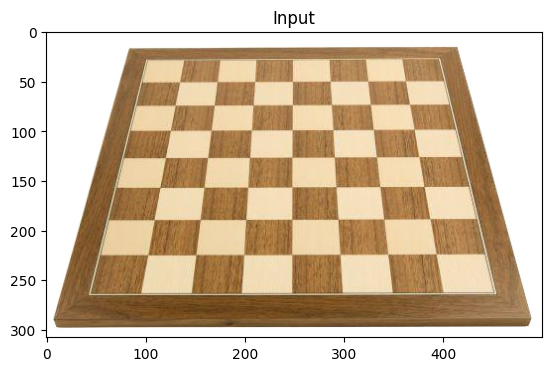

In [17]:
img = cv2.imread("../images/mb7232050_jpg.rf.250c393e5af92ebca937e7b30032c784.jpg")
# img = cv2.resize(img, None, fx=0.5, fy=0.5)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.title('Input')
plt.show()

# Let Model make Predictions

In [18]:
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
results = model.predict(img, conf=0.5, save=True)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


0: 416x640 4 board corners, 94.4ms
Speed: 1.1ms preprocess, 94.4ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)
Results saved to /home/max/Repositories/GitHub/gradio-chess-tracker/algorithms/runs/detect/predict3


# Read Points from Bounding Boxes

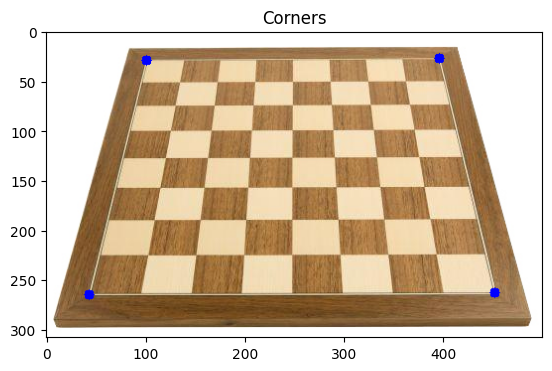

In [19]:
img2 = img.copy()
approx = []

for i in results:
    boxes = i.boxes.xywh
    for box in boxes:
        x, y = box[0], box[1]
        approx.append([x, y])
        cv2.circle(img2, (int(x), int(y)), 5, (0, 0, 255), -1)

plt.imshow(img2)
plt.title('Corners')
plt.show()


# Sort Points

In [20]:
# Get points from contour
pts_1 = np.array(approx, dtype=np.float32).reshape(-1, 2)

xSorted = pts_1[np.argsort(pts_1[:, 0]), :]

leftMost = xSorted[:2, :]
rightMost = xSorted[2:, :]
    
leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
(top_left, bottom_left) = leftMost
 
D = dist.cdist(top_left[np.newaxis], rightMost, "euclidean")[0]
(bottom_right, top_right) = rightMost[np.argsort(D)[::-1], :]

[[     452.54      263.73]
 [     43.906      265.34]
 [     396.96      27.826]
 [     101.06      29.242]]
[[     43.906      265.34]
 [     101.06      29.242]
 [     396.96      27.826]
 [     452.54      263.73]]


# Apply Homography

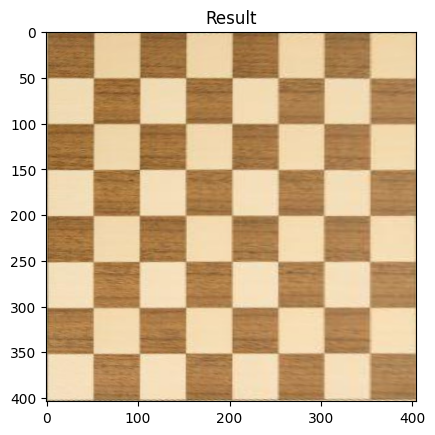

In [21]:
pts_1 = np.array([
    bottom_left,
    top_left,
    bottom_right,
    top_right,
], dtype=np.float32)

height, width, _ = img.shape
img_size = (height+width)//2
pts_2 = np.float32([[0, 0], [img_size, 0], [0, img_size], [img_size, img_size]])

# calculate matrix based on mapping pts_1 to pts_2
M = cv2.getPerspectiveTransform(pts_1, pts_2)

# apply homography
dst = cv2.warpPerspective(img, M, (img_size, img_size))

plt.imshow(dst, cmap='gray')
plt.title('Result')
plt.show()